## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# load in data
prefix = '/home/klawren/oak/pcqtls'
tissue_df = pd.read_csv(f"{prefix}/data/references/selected_tissue_ids.csv", header=0)
tissue_ids = list(tissue_df['Tissue'])

sample_vep = pd.read_csv(f'{prefix}/output/annotations/{tissue_ids[0]}.v8.leadvars.vep.vcf', skiprows=4, sep='\t')

In [3]:
overlap_df = pd.read_csv(f'{prefix}/output/overlap/{tissue_ids[0]}.v8.overlap.txt', sep='\t')
vep_df = pd.merge(sample_vep, overlap_df, left_on='ID', right_on='lead_variant_id', how='outer')

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [4]:
# as an example
sample_vep.iloc[4].INFO

'CSQ=T|upstream_gene_variant|MODIFIER|S1PR1|ENSG00000170989|Transcript|ENST00000305352|protein_coding||||||||||rs2038366&CR104961|1677|1||HGNC|HGNC:3165|ENST00000475821|0.3211|||0&1||||||,T|non_coding_transcript_exon_variant|MODIFIER|S1PR1-DT|ENSG00000225938|Transcript|ENST00000432195|lncRNA|2/2||||840|||||rs2038366&CR104961||-1||HGNC|HGNC:55842|ENST00000475821|0.3211|||0&1||||||,T|upstream_gene_variant|MODIFIER|S1PR1|ENSG00000170989|Transcript|ENST00000475289|protein_coding||||||||||rs2038366&CR104961|2748|1||HGNC|HGNC:3165|ENST00000475821|0.3211|||0&1||||||,T|upstream_gene_variant|MODIFIER|S1PR1|ENSG00000170989|Transcript|ENST00000475821|protein_coding||||||||||rs2038366&CR104961|1523|1|cds_end_NF|HGNC|HGNC:3165|ENST00000475821|0.3211|||0&1||||||,T|upstream_gene_variant|MODIFIER|S1PR1|ENSG00000170989|Transcript|ENST00000561748|protein_coding_CDS_not_defined||||||||||rs2038366&CR104961|1557|1||HGNC|HGNC:3165|ENST00000475821|0.3211|||0&1||||||,T|upstream_gene_variant|MODIFIER|S1PR1|ENS

In [42]:
get_info_list(sample_vep.iloc[4], 1)

['regulatory_region_variant',
 'upstream_gene_variant',
 'non_coding_transcript_exon_variant']

In [5]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [6]:
# explode the rows with multiple annotations, these are seperated by a comma
vep_df['info_list'] = vep_df['INFO'].str.split(',')
exploded_vep = vep_df.explode(column='info_list')
exploded_vep

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    exploded_vep[tag_name] = exploded_vep['info_list'].str.split('|').str[i]

Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


#### Consequence

In [29]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

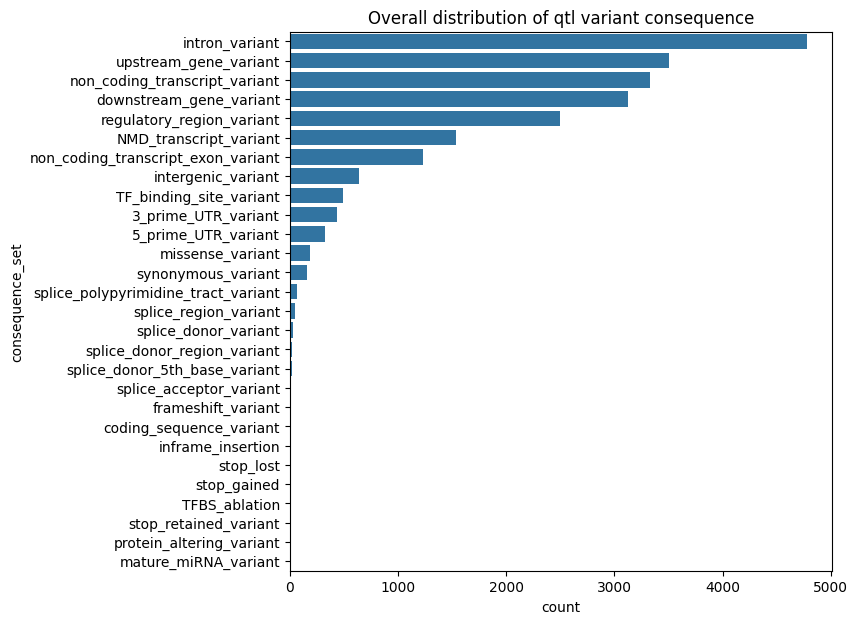

In [48]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_categories)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

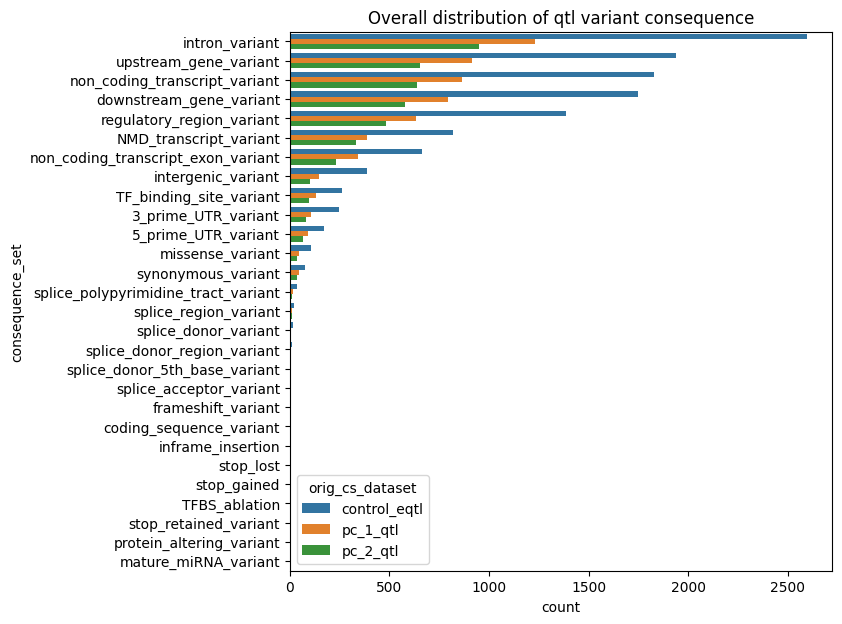

In [49]:
# bar graph with the number of things in each category for pcqtls and eqtls
fig, ax = plt.subplots(figsize=(7,7))

sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_categories, hue='orig_cs_dataset')
plt.title('Overall distribution of qtl variant consequence')
plt.show()

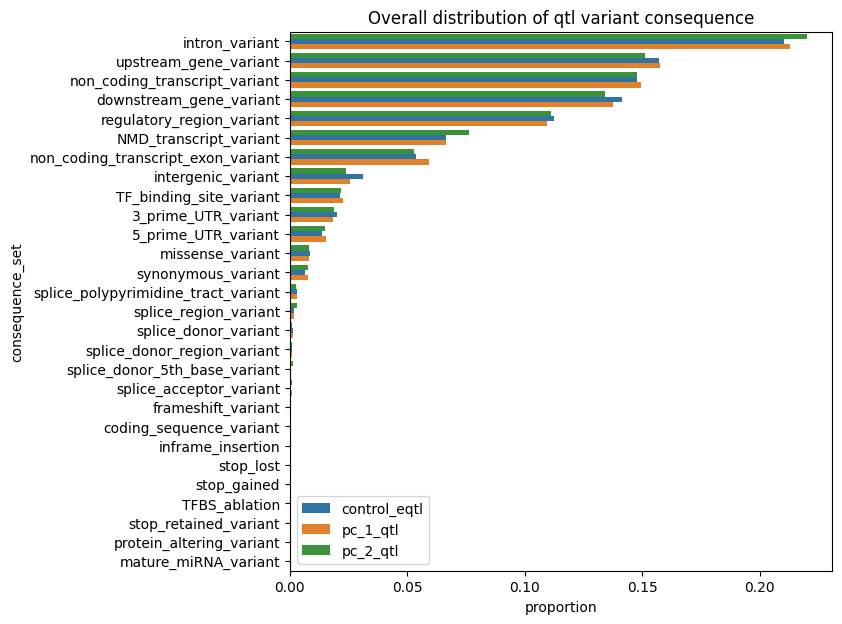

In [69]:
# bar graph with the number of things in each category for pcqtls and eqtls and with each dataset normed individually
fig, ax = plt.subplots(figsize=(7,7))
c_df = vep_df.explode('consequence_set')
datsets = vep_df['orig_cs_dataset'].unique()
for i in range(len(datsets)):
    cs_dataset = datsets[i]
    y = sns.countplot(c_df[c_df['orig_cs_dataset']==cs_dataset], y='consequence_set', ax=ax, order=ordered_categories, label=cs_dataset, stat='proportion')
    if i==0:
        for bar in y.patches:
            bar.set_y(bar.get_y() - bar.get_height()/3)
    elif i==1:
        for bar in y.patches:
            bar.set_y(bar.get_y() + 2*bar.get_height()/3)
plt.title('Overall distribution of qtl variant consequence')
for bar in y.patches:
    bar.set_height(bar.get_height()/3)
plt.show()

In [108]:
# error bars on log odds come from error propegation for counts
def get_odds_error(pcqtl_positive, pcqtl_total, eqtl_positive, eqtl_total):
    pcqtl_negative = pcqtl_total-pcqtl_positive
    eqtl_negative = eqtl_total-eqtl_positive

    # calculate the odds ratio
    or_ratio = (pcqtl_positive / pcqtl_negative) / (eqtl_positive / eqtl_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/pcqtl_positive - 1/pcqtl_negative + 1/pcqtl_positive - 1/eqtl_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return or_ratio, lower_bound, upper_bound


def get_or_counts(vep_df):
    return vep_df.explode('consequence_set').value_counts('consequence_set')

In [138]:
eqtl_counts = get_or_counts(vep_df[vep_df['orig_cs_dataset']=='control_eqtl'])
pcqtl_counts = get_or_counts(vep_df[(vep_df['orig_cs_dataset']=='pc_1_qtl') | (vep_df['orig_cs_dataset']=='pc_2_qtl')])
or_df = pd.DataFrame({'pcqtl_counts':pcqtl_counts, 'eqtl_counts': eqtl_counts})

# add the odds ratios and 95% cis
for idx in or_df.index:
    or_ratio, lower_bound, upper_bound = get_odds_error(or_df.loc[idx]['pcqtl_counts'], or_df['pcqtl_counts'].sum(), or_df.loc[idx]['eqtl_counts'], or_df['eqtl_counts'].sum())
    or_df.loc[idx, 'or_ratio'] = or_ratio
    or_df.loc[idx, 'lower_bound'] = lower_bound
    or_df.loc[idx, 'upper_bound'] = upper_bound

In [140]:
or_df.reset_index()

,pcqtl_counts,eqtl_counts,or_ratio,lower_bound,upper_bound
consequence_set,,,,,
3_prime_UTR_variant,188.0,247,0.928236,0.759666,1.134212
5_prime_UTR_variant,154.0,171,1.101429,0.882340,1.374919
NMD_transcript_variant,715.0,818,1.072658,0.970566,1.185489
TFBS_ablation,1.0,1,1.221320,0.076398,19.524428
TF_binding_site_variant,225.0,263,1.045858,0.871073,1.255716
coding_sequence_variant,2.0,2,1.221342,0.172067,8.669179
downstream_gene_variant,1375.0,1747,0.955134,0.891297,1.023543
frameshift_variant,2.0,3,0.814162,0.114702,5.778984
inframe_insertion,2.0,2,1.221342,0.172067,8.669179


<Axes: ylabel='or_ratio'>

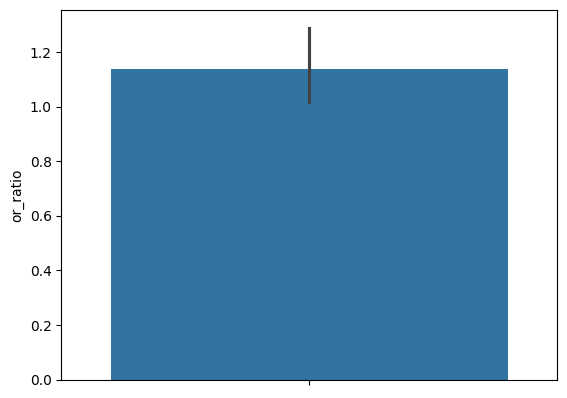

In [139]:
sns.barplot(or_df, y='or_ratio')

Text(0.5, 0, 'Odds ratio')

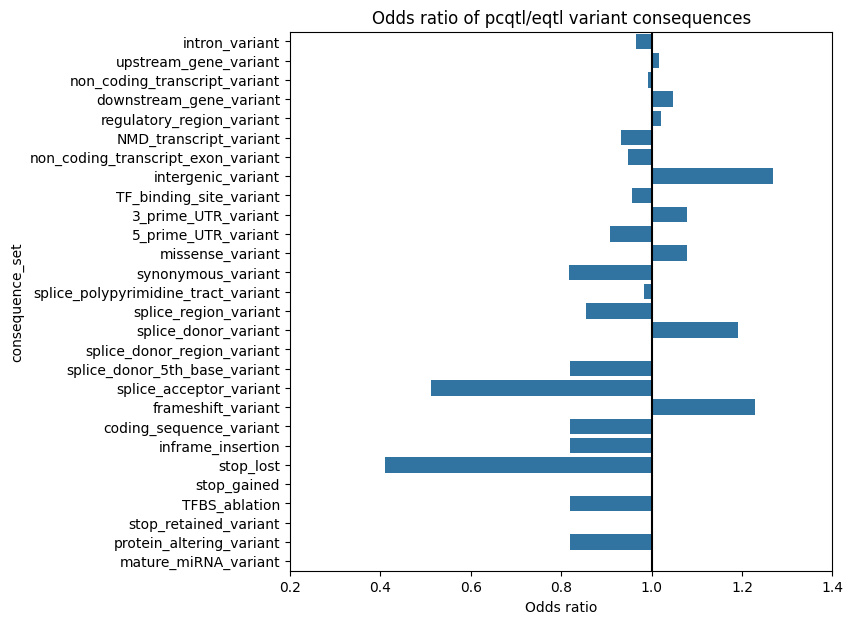

In [99]:
fig, ax = plt.subplots(figsize=(7,7))

# note that data is shifted by 1 to draw bars in the right place
sns.barplot(pc_or/eqtl_or-1, ax=ax, orient='h', order=ordered_categories)
plt.axvline(0, color='k')
locs, labels = plt.xticks()
new_labels = [round(loc + 1, 2) for loc in locs]
plt.xticks(locs, new_labels)
plt.title('Odds ratio of pcqtl/eqtl variant consequences')
plt.xlabel('Odds ratio')